# Klasyfikacja sentymentu
## Zastosowanie osadzeń słów

W tym ćwiczeniu do eksperymentów dodamy wykorzystanie osadzania słów, czyli wektorowe reprezentacje słów. Posłużymy się wytrenowanymi modelami Word2Vec i Glove. Word2vec próbuje uchwycić współwystępowanie słów w jednym oknie jednocześnie, a Glove opiera się na współwystępowaniu słów w całym korpusie.

Zaczniemy od pobrania gotowej reprezentacji wektorowej słów z **Glove** word embeddings ze strony: https://nlp.stanford.edu/data/glove.6B.zip.

In [3]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2024-03-21 17:02:11--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-21 17:02:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  3.31MB/s    in 2m 48s  

2024-03-21 17:05:00 (4.90 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



Następnie rozpakujemy pliki lokalnie korzystając z biblioteki `zipfile` i wrappera `ZipFile` oraz metody `extractall`.

In [4]:
from zipfile import ZipFile
with ZipFile('glove.6B.zip', 'r') as z:
  z.extractall()

Teraz zaimportujemy potrzebne biblioteki, w tym Pandas, gensim oraz Keras:

In [5]:
import pandas as pd
import numpy as np

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from keras.models import Sequential, Model
from keras import layers

from sklearn.model_selection import train_test_split

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

Możemy podłączyć dysk Google, żeby mieć dostęp do zasobów, w tym pliku z recencjami Amazona.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Wczytujemy dane do `dataframe` i możemy podejrzeć zawartość, korzystając z metody `sample`.

In [7]:
path_to_data = '/content/drive/MyDrive/ZUM/02/Musical_instruments_reviews.csv' # UWAGA: ta ścieżka jest do moich danych na dysku, naleŻy to zmienić u siebie

In [8]:
df = pd.read_csv(path_to_data)
df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
7289,AG8FGAIPRBKIR,B002GYWBJ6,Jolly Roger,"[3, 3]",I had been looking for an amp for home practic...,5.0,Blown Away,1359590400,"01 31, 2013"
6658,A2IMZNPSJGB2HQ,B001L8MDMS,Fernando Valenzuela,"[2, 2]",I swapped out the pickguard on my American Sta...,5.0,Does what it should,1336953600,"05 14, 2012"
5140,A34VZEFXQJJ7AT,B000N5MK8M,Guitarslim,"[0, 0]",The ebow is a crazy concept. It's fun to use a...,5.0,Pretty cool,1393372800,"02 26, 2014"
9339,A37U8NH2CD9EDX,B005NACC6M,J. Vento,"[1, 2]",I purchased the DR-40 for use in field recordi...,4.0,Purchased for amateur field recordings,1360713600,"02 13, 2013"
8203,A14B2YH83ZXMPP,B003VWJ2K8,Lonnie M. Adams,"[0, 0]","After reviewing people reviewer, I had no dout...",5.0,Just what I Expect,1399852800,"05 12, 2014"


Wczytany zbiór należy najpierw sprawdzić, czy nie zawiera brakujących wartości metodą `isna`, a następnie zastąpić puste wartości w kolumnie `reviewText` na spacje. Potem konkatenujemy ze sobą zawartość kolumn `reviewText` oraz `summary` do nowej kolumny `reviewAll`.

In [9]:
df.isna().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [10]:
df['reviewText'].fillna(" ", inplace=True)

In [11]:
df['reviewText'] = df['reviewText'] + df['summary']

Sprawdzamy jakie wartości znajdują się w kolumnie z etykietą overall z pomocą `value_counts`.

In [12]:
df['overall'].value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

Musimy zamienić etykiety, tak, żeby mieć dwie oceny `0` dla klasy negatywnej i `1` dla klasy pozytywnej. Recencje z ocenami 1-3 zaklasyfikujemy jako `0`, a z ocenami 4-5 jako `1`. Napisz funkcję `convert_to_labels` i za pomocą `apply` utwórz kolumnę `labels`.

In [13]:
def convert_to_label(value):
  if value == 1 or value == 2 or value == 3:
    return 0
  else:
    return 1

df['label'] = df.overall.apply(convert_to_label)

Sprawdź jak rozkłada się podział ocen z `value_counts`.

In [14]:
df.sample(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,label
1887,A1QDSJZQWJZOL1,B0002E4Z8M,T. Cox,"[38, 38]",What you need to know about this mic:1) This m...,5.0,"Natural sounding, but positioning is everything",1313020800,"08 11, 2011",1
7979,A2BK5M8IYNF7CV,B003JJQMD8,"J. Sanabria ""Deux bleus""","[0, 0]",I bought this audio cable and all I gotta say ...,5.0,Good Stuff.,1370390400,"06 5, 2013",1
4815,A26Y7G0VFYUYSL,B000J5XS3C,Larry Johnson,"[1, 1]",This mixer is just what I've been looking for....,5.0,First mixer. 1 word. Amazing.,1389657600,"01 14, 2014",1


In [15]:
df['label'].value_counts()

1    9022
0    1239
Name: label, dtype: int64

Wczytany zbiór zawiera teksty i klasę sentymentu w 2 kolumnach. Teksty należy najpierw stokenizować, a potem umieśćić w gęstej tablicy. Użyjemy to tego klasy `Tokenizer` i ustawimy w niej jakąś maksymalną ilość słów (np. 4000). Potem zatosujemy metodę `fit_on_texts` żeby przeanalizować kolumnę z tekstami i na końcu użyjemy metody `text_to_sequences` żeby ją zamienić na sekwencje tokenów.

Potem dodatkowo musimy jeszcze zastosować metodę `pad_sequences` żeby wyrównać długość wszystkich zdań do tego samego rozmiaru (żeby je można umieścić w macierzy) - maksymalną długość ustaw na 100:

In [16]:
max_words = 40000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)

texts = df.reviewText.to_list()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('We have %s unique tokens.' % len(word_index))

We have 22813 unique tokens.


In [17]:
data = pad_sequences(sequences, maxlen=max_len)
print(data)

[[   0    0    0 ...  195 3125   24]
 [   4    7  255 ...   10   99 7693]
 [   0    0    0 ...    1  189   40]
 ...
 [   3  860    2 ...   24    8  995]
 [  37   49 1282 ... 2182 1066  111]
 [ 124 1311  526 ... 1416   51  145]]


Po przetworzeniu danych wejśćiowych, warto też przetworzyć dane wyjściowe (kolumnę target) używając metody `to_categorical` (ilość klas ustaw na 2):

In [18]:
labels = to_categorical(df['label'], num_classes=2)
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Teraz można użyć `train_test_split` tak jak w poprzednim ćwiczeniu. Ustaw żeby zbiór testowy był 10% zbioru danych i zastosuj stratyfikację i random state:

In [64]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

## Model 1 - Glove embeddings

Zaczniemy od wczytania osadzeń słów do pamięci. Możemy po wczytaniu wyświetlić ich ilość.

In [21]:
embeddings_index = dict()
f = open('./glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print(f'Loaded {len(embeddings_index)} word vectors.')

Loaded 400000 word vectors.


Następnie stworzymy macierz ebeddingów korzystając z wytrenowanych wektorów Glove, które korzystając z ogólnego występowania słów w korpusie do modelowania relacji.

In [22]:
# sprawdzamy wielkość słownika
vocab = tokenizer.sequences_to_texts(texts)
vocab_size = len(tokenizer.word_index) + 1 # Dodajemy 1 bo indeks 0 jest już zarezerwowany
print(vocab_size)

# tworzymy macierz
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

22814


Użyj klasy `Sequential` żeby stworyć model i dodaj do niego kolejno warstwy:
1. `Input` - to zainicjalizuje tensor Kerasa, jako `shape` podaj krotkę jednoelementową `(max_len,)`, dodatkowo podaj typ danych `dtype='int32'`
2. `Embedding` - to zamieni sekwencję tokenów na kodowanie wektorowe, przekaż jako `input_dim` wielkość słownika czyli `vocab_size`, `output_dim` ustaw na 100, bo korzystamy z modelu Glove 100d, `weights` - przekaż macierz z embeddingiem, `input_length=max_len` oraz `trainable=True`
3. `Flatten` - to zmiejszy wyjście to tensora 1D
4. `Dense` - ustaw ilość komórek na 100 i funkcję aktywacji "relu"
5. `Dense` - ustaw ilość komórek na 32 i funkcję aktywacji "relu"
6. `Dense` - ustaw ilość komórek na 2 i funkcję aktywacji "softmax", która zbierze wszystkie wyjścia do klasyfikacji.

Po stworzeniu modelu, skompiluj go używając optimizera `'adam'`, funkcję kosztu `'categorical_crossentropy'` oraz dodaj `['accuracy']` do metryk.

Na koniec uruchom metodę `fit` na danych treningowych i jako walidacyjne podaj dane testowe. Uruchom procedurę wstępnie na 5 epok, dodat `bacth_size=32` oraz `verbose=True`:

In [23]:
model1 = Sequential()

model1.add(layers.Input(shape=(max_len), dtype='int32', name='review_input'))
model1.add(layers.Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_len, trainable=True))
model1.add(layers.Flatten())
model1.add(layers.Dense(units=100, activation='relu'))
model1.add(layers.Dense(units=32, activation='relu'))
model1.add(layers.Dense(units=2, activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2281400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 100)               1000100   
                                                                 
 dense_1 (Dense)             (None, 32)                3232      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3284798 (12.53 MB)
Trainable params: 3284798 (12.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


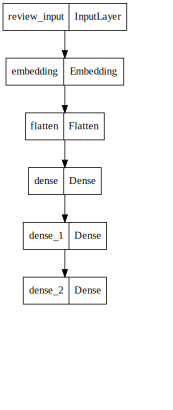

In [24]:
print(model1.summary())
SVG(model_to_dot(model1).create(prog='dot', format='svg'))

In [25]:
history1 = model1.fit(X_train,y_train, epochs=5, batch_size=32, verbose = True, validation_data=(X_val, y_val))

Epoch 1/5
206/206 [==============================] - 14s 61ms/step - loss: 0.3712 - accuracy: 0.8754 - val_loss: 0.3212 - val_accuracy: 0.8794
Epoch 2/5
206/206 [==============================] - 15s 72ms/step - loss: 0.2267 - accuracy: 0.9103 - val_loss: 0.4055 - val_accuracy: 0.8812
Epoch 3/5
206/206 [==============================] - 10s 48ms/step - loss: 0.1036 - accuracy: 0.9595 - val_loss: 0.3928 - val_accuracy: 0.8788
Epoch 4/5
206/206 [==============================] - 13s 64ms/step - loss: 0.0184 - accuracy: 0.9945 - val_loss: 0.5534 - val_accuracy: 0.8806
Epoch 5/5
206/206 [==============================] - 15s 71ms/step - loss: 0.0035 - accuracy: 0.9997 - val_loss: 0.6249 - val_accuracy: 0.8800


## Model 2 - word2vec

Wczytujemy embeddingi z word2vec, które są oparte na relacjach słów w kontekście. Mamy "okno", przez które oglądamy fragment tekstu w korpusie.

In [26]:
path_to_data = '/content/drive/MyDrive/ZUM/02/GoogleNews-vectors-negative300.bin.gz'

In [27]:
embeddings_wv = gensim.models.KeyedVectors.load_word2vec_format(f"{path_to_data}", binary=True)
embeddings_wv.init_sims(replace=True)
embeddings_ap = api.load("glove-wiki-gigaword-100")

<ipython-input-27-8e30713ab5ef>:2: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  embeddings_wv.init_sims(replace=True)


[==================================================] 100.0% 128.1/128.1MB downloaded


In [28]:
# vocab = tokenizer.sequences_to_texts(texts)
# vocab_size = len(tokenizer.word_index) + 1
# print(vocab_size)

# tworzymy macierz
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
	try:
		embedding_vector = embeddings_ap[word]
		if embedding_vector is not None:
			embedding_matrix[i] = embedding_vector
	except:
		pass

Użyj klasy `Sequential` żeby stworyć model i dodaj do niego kolejno warstwy:
1. `Input` - to zainicjalizuje tensor Kerasa, jako `shape` podaj krotkę jednoelementową `(max_len,)`, dodatkowo podaj typ danych `dtype='int32'`
2. `Embedding` - to zamieni sekwencję tokenów na kodowanie wektorowe, przekaż jako `input_dim` wielkość słownika czyli `vocab_size`, `output_dim` ustaw na 100, bo korzystamy z modelu word2vec 100d, `weights` - przekaż macierz z embeddingiem, `input_length=max_len` oraz `trainable=True`
3. `Flatten` - to zmiejszy wyjście to tensora 1D
4. `Dense` - ustaw ilość komórek na 100 i funkcję aktywacji "relu"
5. `Dense` - ustaw ilość komórek na 32 i funkcję aktywacji "relu"
6. `Dense` - ustaw ilość komórek na 2 i funkcję aktywacji "softmax", która zbierze wszystkie wyjścia do klasyfikacji.

Po stworzeniu modelu, skompiluj go używając optimizera `'adam'`, funkcję kosztu `'categorical_crossentropy'` oraz dodaj `['accuracy']` do metryk.

Na koniec uruchom metodę `fit` na danych treningowych i jako walidacyjne podaj dane testowe. Uruchom procedurę wstępnie na 5 epok, dodat `bacth_size=32` oraz `verbose=True`:

In [29]:
model2 = Sequential()

model2.add(layers.Input(shape=(max_len), dtype='int32', name='review_input'))
model2.add(layers.Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_len, trainable=True))
model2.add(layers.Flatten())
model2.add(layers.Dense(units=100, activation='relu'))
model2.add(layers.Dense(units=32, activation='relu'))
model2.add(layers.Dense(units=2, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          2281400   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               1000100   
                                                                 
 dense_4 (Dense)             (None, 32)                3232      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3284798 (12.53 MB)
Trainable params: 3284798 (12.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


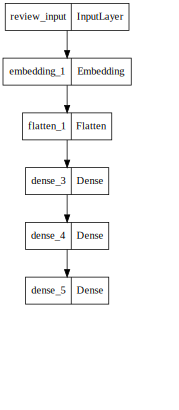

In [30]:
print(model2.summary())
SVG(model_to_dot(model2).create(prog='dot', format='svg'))

In [31]:
history2 = model2.fit(X_train,
                      y_train,
                      epochs=5,
                      batch_size=32,
                      verbose=True,
                      validation_data=(X_val, y_val))

Epoch 1/5
206/206 [==============================] - 13s 57ms/step - loss: 0.3790 - accuracy: 0.8680 - val_loss: 0.3209 - val_accuracy: 0.8800
Epoch 2/5
206/206 [==============================] - 15s 73ms/step - loss: 0.1947 - accuracy: 0.9222 - val_loss: 0.3801 - val_accuracy: 0.8788
Epoch 3/5
206/206 [==============================] - 11s 52ms/step - loss: 0.0668 - accuracy: 0.9778 - val_loss: 0.4821 - val_accuracy: 0.8727
Epoch 4/5
206/206 [==============================] - 13s 63ms/step - loss: 0.0220 - accuracy: 0.9925 - val_loss: 0.5588 - val_accuracy: 0.8544
Epoch 5/5
206/206 [==============================] - 15s 72ms/step - loss: 0.0034 - accuracy: 0.9997 - val_loss: 0.7454 - val_accuracy: 0.8752


# Model 3

In [34]:
#Training time was ohhhhh too long
model3 = Sequential()

from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout


model3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_len, trainable=True),
    GRU(128, return_sequences=True),
    GRU(128),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
])

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          2281400   
                                                                 
 gru_2 (GRU)                 (None, 100, 128)          88320     
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2477178 (9.45 MB)
Trainable params: 2477

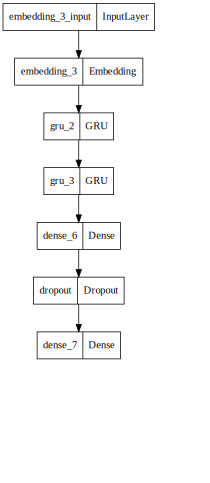

In [35]:
print(model3.summary())
SVG(model_to_dot(model3).create(prog='dot', format='svg'))

In [36]:
history3 = model3.fit(X_train,
                      y_train,
                      epochs=5,
                      batch_size=32,
                      verbose=True,
                      validation_data=(X_val, y_val))

Epoch 1/5
206/206 [==============================] - 96s 442ms/step - loss: 0.3545 - accuracy: 0.8795 - val_loss: 0.2926 - val_accuracy: 0.8800
Epoch 2/5
206/206 [==============================] - 84s 407ms/step - loss: 0.2542 - accuracy: 0.8946 - val_loss: 0.2646 - val_accuracy: 0.8898
Epoch 3/5
206/206 [==============================] - 76s 369ms/step - loss: 0.1705 - accuracy: 0.9270 - val_loss: 0.3149 - val_accuracy: 0.8995
Epoch 4/5
206/206 [==============================] - 81s 394ms/step - loss: 0.0969 - accuracy: 0.9644 - val_loss: 0.3896 - val_accuracy: 0.8618
Epoch 5/5
206/206 [==============================] - 80s 391ms/step - loss: 0.0369 - accuracy: 0.9872 - val_loss: 0.5429 - val_accuracy: 0.8733


# Model 4

In [75]:
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout


model4 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_len, trainable=True),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
])

model4.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_60 (Embedding)    (None, 100, 100)          2281400   
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 19, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 15, 128)           82048     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_125 (Dense)           (None, 128)             

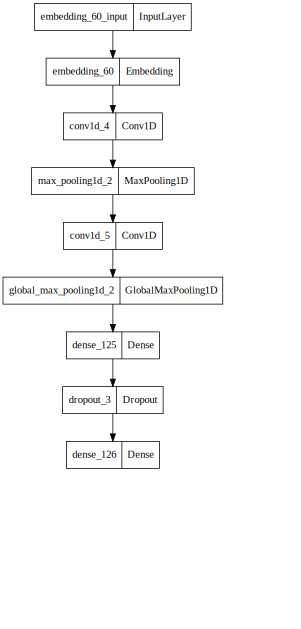

In [76]:
print(model4.summary())
SVG(model_to_dot(model4).create(prog='dot', format='svg'))

In [77]:
history4 = model4.fit(X_train,
                      y_train,
                      epochs=5,
                      batch_size=32,
                      verbose=True,
                      validation_data=(X_val, y_val))

Epoch 1/5
206/206 [==============================] - 30s 139ms/step - loss: 0.3812 - accuracy: 0.8753 - val_loss: 0.3535 - val_accuracy: 0.8794
Epoch 2/5
206/206 [==============================] - 28s 137ms/step - loss: 0.3201 - accuracy: 0.8794 - val_loss: 0.2922 - val_accuracy: 0.8794
Epoch 3/5
206/206 [==============================] - 17s 82ms/step - loss: 0.2392 - accuracy: 0.9016 - val_loss: 0.2895 - val_accuracy: 0.8843
Epoch 4/5
206/206 [==============================] - 22s 108ms/step - loss: 0.1322 - accuracy: 0.9487 - val_loss: 0.3954 - val_accuracy: 0.8873
Epoch 5/5
206/206 [==============================] - 18s 87ms/step - loss: 0.0509 - accuracy: 0.9829 - val_loss: 0.5273 - val_accuracy: 0.8916


Ulepszenie modelu nr 4

Dodałem EarlyStopping i warstwę dropout, ale nie pomogło to pozbyć się potecjalnego przetrenowania :(

In [78]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

def build_model(vocab_size, max_len, embedding_matrix):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_len, trainable=True),
        Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling1D(5),
        Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.001)),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(2, activation='sigmoid')
    ])
    return model

model4 = build_model(vocab_size=vocab_size, max_len=max_len, embedding_matrix=embedding_matrix)

model4.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_61 (Embedding)    (None, 100, 100)          2281400   
                                                                 
 conv1d_6 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 19, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 15, 128)           82048     
                                                                 
 global_max_pooling1d_3 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_127 (Dense)           (None, 128)             

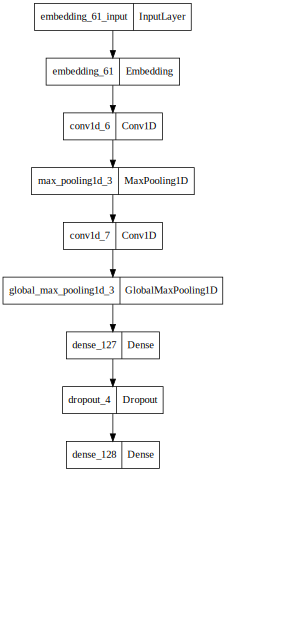

In [79]:
print(model4.summary())
SVG(model_to_dot(model4).create(prog='dot', format='svg'))

In [80]:
history4 = model4.fit(X_train, y_train, epochs=20, batch_size=32, verbose=True, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/20
206/206 [==============================] - 27s 127ms/step - loss: 0.6074 - accuracy: 0.8768 - val_loss: 0.4784 - val_accuracy: 0.8794
Epoch 2/20
206/206 [==============================] - 25s 122ms/step - loss: 0.4208 - accuracy: 0.8791 - val_loss: 0.3792 - val_accuracy: 0.8794
Epoch 3/20
206/206 [==============================] - 17s 84ms/step - loss: 0.3175 - accuracy: 0.8981 - val_loss: 0.4474 - val_accuracy: 0.7795
Epoch 4/20
206/206 [==============================] - 28s 138ms/step - loss: 0.2523 - accuracy: 0.9264 - val_loss: 0.3601 - val_accuracy: 0.8812
Epoch 5/20
206/206 [==============================] - 22s 107ms/step - loss: 0.1780 - accuracy: 0.9535 - val_loss: 0.4154 - val_accuracy: 0.8922
Epoch 6/20
206/206 [==============================] - 18s 88ms/step - loss: 0.1205 - accuracy: 0.9776 - val_loss: 0.4477 - val_accuracy: 0.8782
Epoch 7/20
206/206 [==============================] - 23s 111ms/step - loss: 0.0859 - accuracy: 0.9898 - val_loss: 0.6562 - val_accu

# Wizualizacja i konkluzje

Narysuj historię oraz wyniki powyższych 3 modeli.

In [ ]:
!pip install plot_keras_history

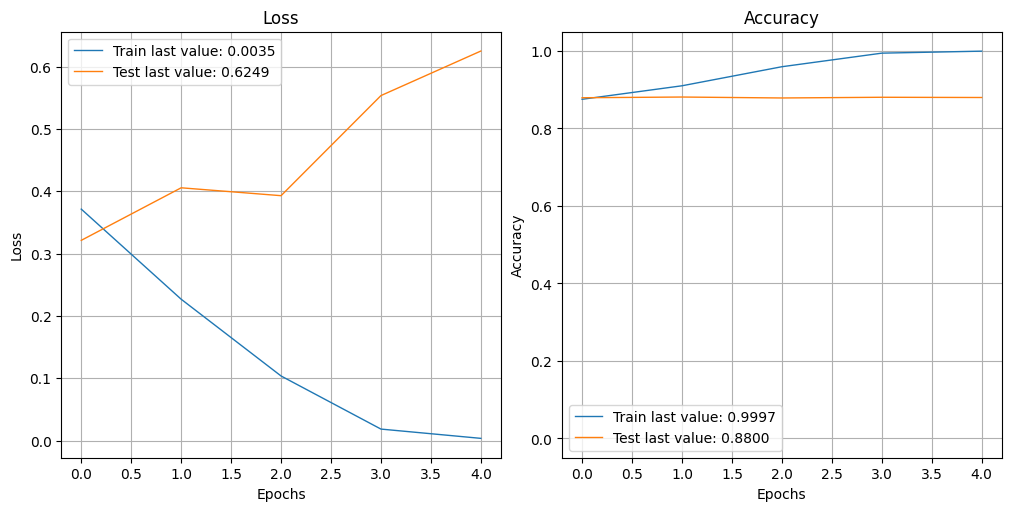

In [42]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1)
plt.close()

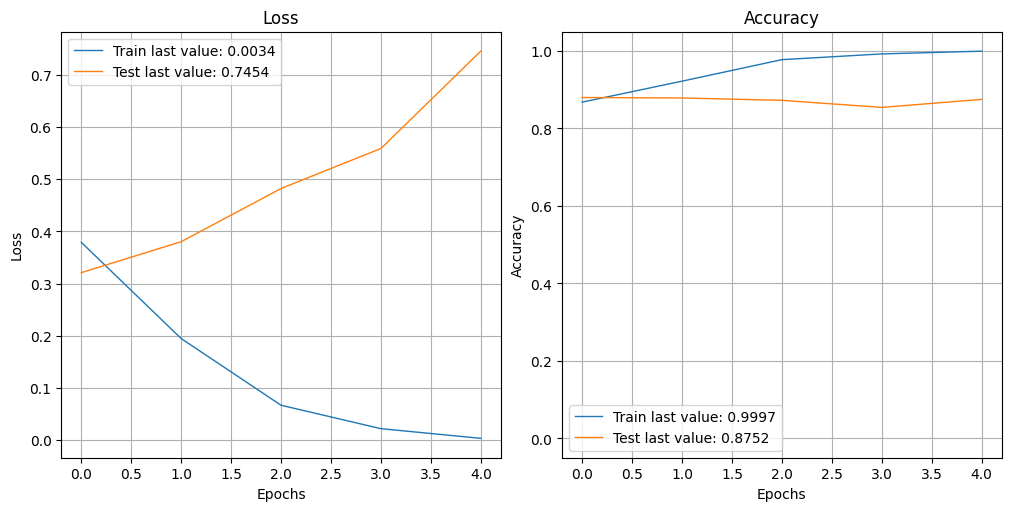

In [43]:
show_history(history2)
plot_history(history2)
plt.close()

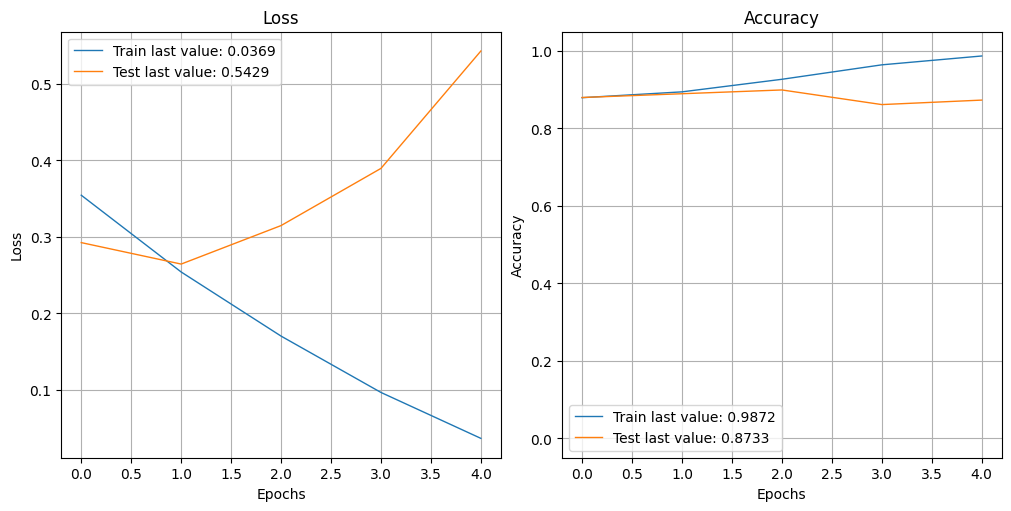

In [44]:
show_history(history3)
plot_history(history3)
plt.close()

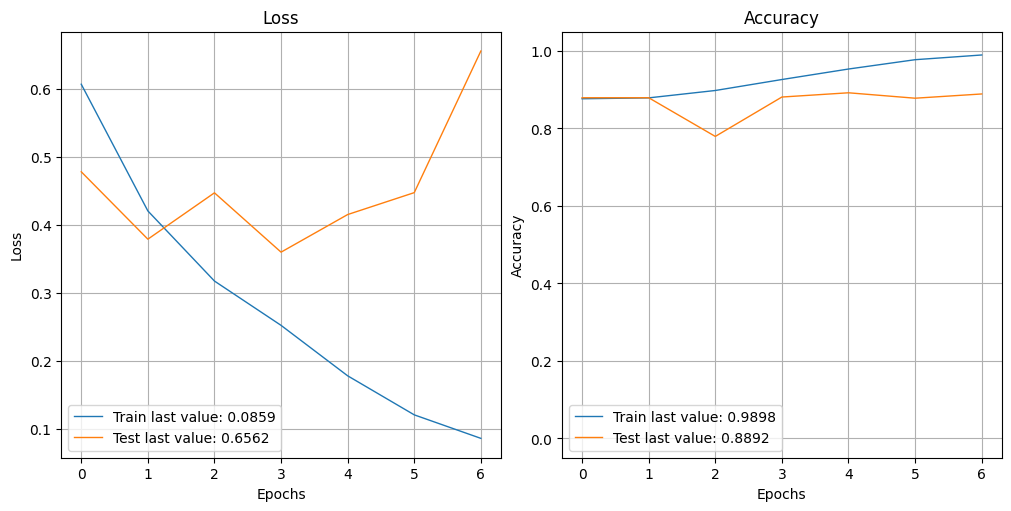

In [81]:
show_history(history4)
plot_history(history4)
plt.close()

W 3. F1 score, zrobić trzeci model i sprawdzic jak on działa
W 1. CV i pozmieniać hipeparametry i zostawić jakiś komentarz jak to się nam zmienia i zobaczyć(pobawić się z tym)
one maja overfitting i mamy starać się zrobić lepsze modele

# PRACA DOMOWA:

1. Porównaj historię oraz wyniki powyższych 3 modeli. Porównaj też ich prędkość. Spróbuj zmienić ich hiperparametry.
2. Czy jest jakaś lepsza topologia niż zapropownowane wyżej? Zaprojektuj inną sieć dla powyższych danych (np. CNN/LSTM/GRU) i sprawdź wyniki.
3. Przygotuj funkcję ewaluacji do modeli, która ma zwracać wynik sieci na zbiorze testowym.
4. Na koniec uruchom najlepszy model (wybrany na podstawie funkcji ewaluacji) na większą ilość epok.


# Zadanie 1

U góry zaproponowałem dwie inne architektury. Niestety GRU uczy się bardzo długo, więc stwierdziłem, że nie będę go rozwijał i starałem się ulepszyć model CNN.

Sprawdziłem różne hiperparametry tylko na jednej sieci, ponieważ RandomSearchCV na poniższym modelu trwał jakieś 30 minut, więc nie miało to sensu do przeszukiwania na każdym i zostawiam tylko ten. W przypadku konieczności sprawdzenia wszystkich jest to możliwe, ale na pewno nie opłacalne.

In [70]:
print(y_train.shape)  # RandomSearchCV przyjmuje tylko format (liczba_próbek, liczba_klas)

(6566, 2)


In [71]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

def create_model(units=32, activation='relu'):
    model = Sequential([
        Input(shape=(max_len), dtype='int32', name='review_input'),
        Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_len, trainable=True),
        Flatten(),
        Dense(units=units, activation=activation),
        Dense(units=units, activation=activation),
        Dense(units=2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, epochs=10, verbose=0)

# uczenie trwa bardzo długo, więc dałem tylko to do sprawdzenia
param_dist = {
    'model__units': [32, 64, 128],
    'model__activation': ['relu', 'tanh'],
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=1)

random_search_results = random_search.fit(X_train, y_train)

print("Najlepsze parametry: %s" % random_search_results.best_params_)
print("Najlepsza dokładność: %.2f%%" % (random_search_results.best_score_ * 100))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Najlepsze parametry: {'model__units': 64, 'model__activation': 'relu'}
Najlepsza dokładność: 87.89%


Podstawienie najlepszych parametrów

In [82]:
model1 = Sequential()

model1.add(layers.Input(shape=(max_len), dtype='int32', name='review_input'))
model1.add(layers.Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_len, trainable=True))
model1.add(layers.Flatten())
model1.add(layers.Dense(units=64, activation='relu'))
model1.add(layers.Dense(units=64, activation='relu'))
model1.add(layers.Dense(units=2, activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_62 (Embedding)    (None, 100, 100)          2281400   
                                                                 
 flatten_56 (Flatten)        (None, 10000)             0         
                                                                 
 dense_129 (Dense)           (None, 64)                640064    
                                                                 
 dense_130 (Dense)           (None, 64)                4160      
                                                                 
 dense_131 (Dense)           (None, 2)                 130       
                                                                 
Total params: 2925754 (11.16 MB)
Trainable params: 2925754 (11.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


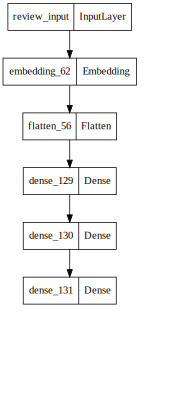

In [83]:
print(model1.summary())
SVG(model_to_dot(model1).create(prog='dot', format='svg'))

In [84]:
history1 = model1.fit(X_train,y_train, epochs=5, batch_size=32, verbose = True, validation_data=(X_val, y_val))

Epoch 1/5
206/206 [==============================] - 17s 78ms/step - loss: 0.3672 - accuracy: 0.8792 - val_loss: 0.3494 - val_accuracy: 0.8794
Epoch 2/5
206/206 [==============================] - 15s 74ms/step - loss: 0.2473 - accuracy: 0.8967 - val_loss: 0.3101 - val_accuracy: 0.8800
Epoch 3/5
206/206 [==============================] - 12s 58ms/step - loss: 0.0999 - accuracy: 0.9636 - val_loss: 0.4029 - val_accuracy: 0.8745
Epoch 4/5
206/206 [==============================] - 14s 69ms/step - loss: 0.0231 - accuracy: 0.9941 - val_loss: 0.5174 - val_accuracy: 0.8739
Epoch 5/5
206/206 [==============================] - 10s 47ms/step - loss: 0.0060 - accuracy: 0.9994 - val_loss: 0.6387 - val_accuracy: 0.8819


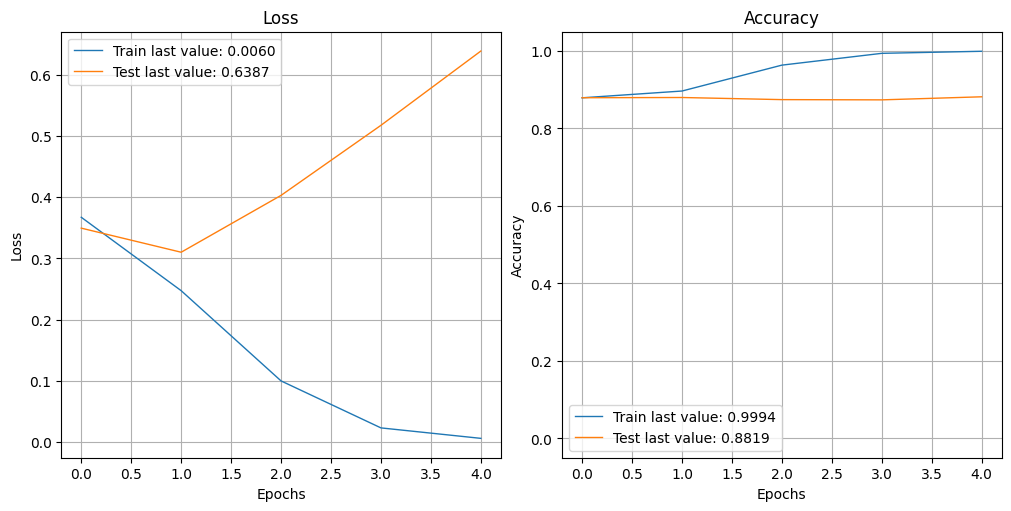

In [85]:
show_history(history1)
plot_history(history1)
plt.close()

#Zadanie 3

#Ewaluacja wyników powyższych modeli

In [86]:
from sklearn.metrics import f1_score

def find_best_model(models, X_val, y_val):
    best_score = -1
    best_model_name = None
    results = {}

    for name, model in models.items():
        y_pred = model.predict(X_val)
        y_pred = np.argmax(y_pred, axis=1)
        if y_val.shape[1] > 1:
            y_true = np.argmax(y_val, axis=1)
        else:
            y_true = y_val
        f1 = f1_score(y_true, y_pred, average='macro')
        results[name] = {'F1-score': f1}

        if f1 > best_score:
            best_score = f1
            best_model_name = name

    return best_model_name, best_score, results

models = {
    'model1': model1,
    'model2': model2,
    'model3': model3,
    'model4': model4
}

best_model_name, best_score, results = find_best_model(models, X_val, y_val)

print(f"Najlepszy model: {best_model_name} z F1-score: {best_score:.4f}")
for name, result in results.items():
    print(f"{name} - F1-score: {result['F1-score']:.4f}")

52/52 [==============================] - 1s 15ms/step
Najlepszy model: model3 z F1-score: 0.6826
model1 - F1-score: 0.6545
model2 - F1-score: 0.5985
model3 - F1-score: 0.6826
model4 - F1-score: 0.6434


Nawet bez ulepszania modelu GRU okazał się on najlepszy

#Zadanie 4

In [90]:
model3 = Sequential()

model3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_len, trainable=True),
    GRU(128, return_sequences=True),
    GRU(128),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
])

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [91]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

history3 = model3.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    verbose=True,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/20
206/206 [==============================] - 138s 608ms/step - loss: 0.3432 - accuracy: 0.8744 - val_loss: 0.2855 - val_accuracy: 0.8782
Epoch 2/20
206/206 [==============================] - 78s 382ms/step - loss: 0.2537 - accuracy: 0.8996 - val_loss: 0.3062 - val_accuracy: 0.8910
Epoch 3/20
206/206 [==============================] - 84s 405ms/step - loss: 0.1787 - accuracy: 0.9272 - val_loss: 0.2800 - val_accuracy: 0.8855
Epoch 4/20
206/206 [==============================] - 82s 401ms/step - loss: 0.1151 - accuracy: 0.9560 - val_loss: 0.3264 - val_accuracy: 0.8952
Epoch 5/20
206/206 [==============================] - 83s 403ms/step - loss: 0.0576 - accuracy: 0.9819 - val_loss: 0.4725 - val_accuracy: 0.8855
Epoch 6/20
206/206 [==============================] - 100s 483ms/step - loss: 0.0181 - accuracy: 0.9947 - val_loss: 0.6220 - val_accuracy: 0.8946
Epoch 6: early stopping


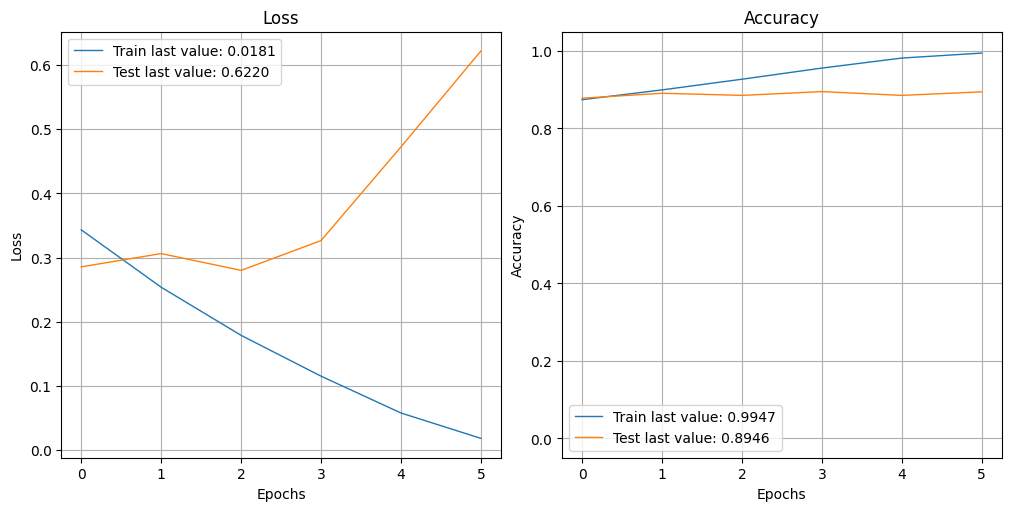

In [92]:
show_history(history3)
plot_history(history3)
plt.close()

Ewaluacja na zbiorze testowym

In [94]:
test_loss, test_accuracy = model3.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

65/65 [==============================] - 4s 55ms/step - loss: 0.2924 - accuracy: 0.8807
Test Loss: 0.2924
Test Accuracy: 0.8807


In [93]:
from sklearn.metrics import classification_report

y_pred = model3.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

if y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

print(classification_report(y_true, y_pred))

65/65 [==============================] - 6s 79ms/step
              precision    recall  f1-score   support

           0       0.51      0.52      0.51       248
           1       0.93      0.93      0.93      1805

    accuracy                           0.88      2053
   macro avg       0.72      0.73      0.72      2053
weighted avg       0.88      0.88      0.88      2053

